# Cubeviz visualization tool

## Introduction

This notebook introduces the basic functionality of the Cubeviz tool.  The aspects we will cover include:

* Launching the tool
* Loading data from a notebook cell
* Adjusting display parameters
* Selecting spatial and spectral regions and passing them to the notebook
* Extracting a spectrum with Cubeviz and passing it to the notebook
* Using the Collapse plugin to extract an image from the cube
* Displaying contours on an image
* Extracting a spectrum from a notebook cell.

The other data analysis plugins will be covered in a future Jwebbinar on IFU and MRS spectroscopy.



## Imports 

* _numpy_ for array math
* _scipy_ for ndcube gaussian smoothing
* _specutils_ for Spectrum1D data model and cube manipulation
* _jdaviz_ : Cubeviz data visualization tool
* _photutils_ to define circular apertures
* _astropy.io_ for reading and writing FITS cubes and images
* _astropy.wcs, units, coordinates_ for defining and reading WCS
* _astropy.stats_ for sigma_clipping
* _astropy.utils_ for downloading files from URLs
* _matplotlib_ for plotting spectra and images

In [1]:
#Resize notebook to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import time

import numpy as np
import scipy

import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region, spectral_slab

from jdaviz import CubeViz

from photutils import CircularAperture, SkyCircularAperture, aperture_photometry
from photutils.detection import DAOStarFinder

from regions import PixCoord, CirclePixelRegion

from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.stats import sigma_clipped_stats
from astropy.utils.data import download_file
import astropy.units as u

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')


## Read in Simulated NIRSpec IFU Cube

A point source (quasar) was simulated using the NIRSpec Instrument Performance Simulator (IPS), then run through the JWST Spec2 pipeline. We will use this for our science dataset.

Read in the data both with fits.open (to inspect the data structure and header) and Spectrum1D.read to utilize specutils functionality.

In [3]:
#Download the cube data from Box
filename = "https://stsci.box.com/shared/static/ff0bj31acot1272x5qq2clbmto3s6v4f.fits"
cube_file = download_file(filename, cache=True)

# Open and inspect the file with astropy.fits.open
with fits.open(cube_file, memmap=False) as hdulist:
    hdulist.info()
    sci = hdulist['SCI'].data
    err = hdulist['ERR'].data  
    
# Load original (untrimmed version) with Spectrum1D    
spec1d_untrimmed = Spectrum1D.read(cube_file, format='JWST s3d')
wavelength_untrimmed = spec1d_untrimmed.spectral_axis
print()
print("Wavelength: ", wavelength_untrimmed)

Filename: /var/folders/cw/tytqv5y91qd3j4_stwnc03c80001ww/T/astropy-download-39272-bk32664h
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     276   ()      
  1  SCI           1 ImageHDU        64   (37, 43, 3945)   float32   
  2  ERR           1 ImageHDU        12   (37, 43, 3945)   float32   
  3  DQ            1 ImageHDU        12   (37, 43, 3945)   int32 (rescales to uint32)   
  4  WMAP          1 ImageHDU        10   (37, 43, 3945)   float32   
  5  HDRTAB        1 BinTableHDU    788   8R x 389C   [23A, 56A, D, 72A, 10A, 20A, D, 5A, 7A, 13A, 4A, D, D, D, D, D, 4A, 11A, 15A, 7A, 3A, 3A, 3A, K, 10A, 15A, D, D, 56A, 1A, 5A, 3A, 3A, 2A, 1A, 2A, 5A, D, 3A, 5A, D, D, 7A, 19A, D, K, L, L, D, D, 7A, 14A, 5A, D, D, D, D, D, D, 23A, D, D, 7A, 7A, 4A, D, D, 6A, D, D, 5A, D, 4A, K, D, D, D, 22A, 3A, K, D, 7A, 4A, D, D, D, D, D, D, D, D, D, K, D, 7A, D, D, D, D, D, D, D, D, D, 12A, D, D, D, K, D, D, K, K, D, D, K, K, D, D, K, D, D, D, D, D, D, D

## Visualize Science Data with Cubeviz

In [4]:
cubeviz = CubeViz()
cubeviz.app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
2021-05-05 13:26:02,696 - stpipe - WARNING - PossiblySlowWarning: This function (<function BaseSpectralCube.sum at 0x168cbcee0>) requires loading the entire cube into memory and may therefore be slo

### UI Instructions:
#### Task 1:  Load the cube and view it
* Load science datacube into Cubeviz using the next code cell below
* Go to Tools icon: Gear icon: Layer in the leftmost image viewer 
* In that tab, change the stretch to Logarithmic, 99.5 percentile to see the target PSF wings.
* Scrub through the cube using the Slice slider.

#### Task 2:  Extract a spectrum from a region (subset) of the cube
* Select a circular subset region centered on the source, using the region selection tool under the Tools icon. 
* Note that the region is pixelated and doesn't include fractional pixels.
* Change the collapse method to "Sum" in spectrum viewer: Tools icon: Gear icon : Viewer. (Note that the collapse method is for the erroneously labeled 2nd "x axis")
* Adjust the size and location of the region until you are happy with the extraction that shows up in the spectrum viewer.

#### Task 3: Select a spectral region for further analysis
* In the spectrum viewer, use the vertical and horizontal pan and zoom to focus on the broad H-alpha line (redshifted to 1.64 microns).  To pan: drag and drop spectrum with mouse or trackpad. To zoom: scroll with mouse or trackpad.
* Select 'No selection (create new)' in the Subsets menu in the Cubeviz top banner.
* Select a spectral subset region in spectrum viewer, using the region selection tool under the Tools icon, centered on a spectral feature of interest.

#### Task 4: Extract an image by collapsing the cube
* Find the Collapse data analysis Plugin by clicking the 'Lego' icon at upper right.
* Select a dataset to collapse with the Data dropdown (e.g. SCI extension of our cube).
* Enter the cube Axis to collapse (0 for the spectral axis).
* Pick the 'Sum' collapse method.
* Choose a spectral region to collapse in the Spectral Region dropdown (e.g. Subset 2).
* Press 'Apply' 
* Use the 2nd cube/image viewer to display the collapsed data cube image. Go to Tools icon: Gear icon : Data dropdown, deselect the 'ERR' extension checkbox, and select the 'Collapsed' dataset that was generated by the previous step. 
* NB: you may need to resize the viewer(s) in order to see the full tools menu.
* Adjust the Stretch in the viewer as needed.

#### Task 5: Display contours on an image or cube
* Go to Tools icon: Gear icon : Layer in the 2nd viewer
* Make sure the 'SCI' extension is selected.
* Change the stretch in of the collapsed cube image to Logarithmic 95%.
* Click on the Contour 'eye with slash' icon to remove the slash and display the autogenerated contours.
* Click on the wrench icon to enter custom contour levels (try 1e+12, 1e+13, 1e+14 for the collapsed data set). Note: There is a bug that autocorrects scientific notation. Try entering a junk character like '#' at the beginning of each level (e.g. #1e+12, #1e+13, #1e+14) then delete the '#s', as a temporary work-around.

## Load Cube into Cubeviz

In [5]:
time.sleep(2)  # Sleep to avoid glue-jupyter timing issue
cubeviz.app.load_data(cube_file)

2021-05-05 13:21:45,564 - stpipe - WARNING - No spectral axis found; header may be non-compliant.
2021-05-05 13:21:45,617 - stpipe - WARNING - No spectral axis found; header may be non-compliant.
2021-05-05 13:21:45,622 - stpipe - WARNING - No spectral axis found; header may be non-compliant.
2021-05-05 13:21:46,252 - stpipe - WARNING - No spectral axis found; header may be non-compliant.
2021-05-05 13:21:46,466 - stpipe - WARNING - No spectral axis found; header may be non-compliant.
2021-05-05 13:21:46,725 - stpipe - WARNING - No spectral axis found; header may be non-compliant.


## Export Region from Cubeviz
Export the region defined by the user in Cubeviz as an astropy CirclePixel Region, which has units of pixels.  We need "try:, except:" to catch the case where there is no Subset 1 selected in Cubeviz. 

In [6]:
cubeviz_data = cubeviz.app.data_collection[0]
try:
    region1 = cubeviz.app.get_subsets_from_viewer('spectrum-viewer')['Subset 1']
    print(region1)
    region1_exists = True
    center1_xy = [region1.center.x, region1.center.y]  
    r_pix = region1.radius

except Exception:
    print("There are no regions selected in the cube viewer.")
    region1_exists = False
    center1_xy = [17.1, 20.]
    r_pix = 6.0
      

Region: CirclePixelRegion
center: PixCoord(x=18.353933334350586, y=20.06417465209961)
radius: 5.142389297485352


/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

## Extract Subset Spectrum in Cubeviz Spectrum Viewer
Retrieve the spectrum (Subset1) of the user-defined region from the Spectrum Viewer as a Spectrum1D object. Trim to remove bad wavelength ranges.

In [7]:
wave_trim =[1.0*u.um,1.88*u.um]
trim_region = SpectralRegion(wave_trim[0], wave_trim[1])
try:
    spectrum_subset1_untrimmed = cubeviz.app.get_data_from_viewer('spectrum-viewer')['Subset 1']
    print(spectrum_subset1_untrimmed)
    
    # Trim the extracted spectrum
    spectrum_subset1 = extract_region(spectrum_subset1_untrimmed, trim_region)
    
    print()
    print('Wavelength:', spectrum_subset1_untrimmed.spectral_axis)
    print('Trimmed:', spectrum_subset1.spectral_axis)
    print()

except Exception:
    print("There are no subsets selected in the spectrum viewer.")
    

#spectrum_subset1_untrimmed = spectrum_subset1_untrimmed.with_spectral_unit(u.um)


/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/pogle/miniconda3/envs/jdaviz1.1/lib/python3.9/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

Spectrum1D (length=3945)
flux:             [ 3.7779e+14 MJy / sr, ..., 2.1271e+14 MJy / sr ],  mean=3.7849e+14 MJy / sr
spectral axis:    [ 9.6652e-07 m, ..., 1.8934e-06 m ],  mean=1.4299e-06 m

Wavelength: [9.66521456e-07 9.66756456e-07 9.66991456e-07 ... 1.89289145e-06
 1.89312645e-06 1.89336145e-06] m
Trimmed: [1.00012646e-06 1.00036146e-06 1.00059646e-06 ... 1.87949645e-06
 1.87973145e-06 1.87996645e-06] m



## Extract Spectrum in Linearly Expanding Circular Aperture (Cone)
This method is appropriate for a point source PSF with width proportional to wavelength

In [8]:
# Trim the data cube and adjust region location
x_trim = [2,-1]
y_trim = [5, -4]
spec1d = spectral_slab(spec1d_untrimmed, wave_trim[0], wave_trim[1])[x_trim[0]:x_trim[1],y_trim[0]:y_trim[1],:]
wavelength = spec1d.spectral_axis
spec1d_len = len(wavelength.value)

#Adjust region location in trimmed cube
center_trim = PixCoord(x=center1_xy[0]-x_trim[0], y=center1_xy[1]-y_trim[0])
region_trim = CirclePixelRegion(center=center_trim, radius=r_pix)
print(region_trim)

center_x = center_trim.x
center_y = center_trim.y

#Use photutils.aperture_photometry to measure flux in expanding aperture
cone_sum = []
for idx in range(spec1d_len):
    r_cone = r_pix * wavelength.value[idx]/ wavelength.value[0]
    aperture_cone = CircularAperture((center_x,center_y), r=r_cone)
    phot_table = aperture_photometry(spec1d.flux.value[:, :, idx], aperture_cone)
    cone_sum.append(phot_table['aperture_sum'][0])
    
cone = Spectrum1D(flux=np.array(cone_sum)*u.MJy/u.sr, spectral_axis=spec1d.spectral_axis)
print(cone)


Region: CirclePixelRegion
center: PixCoord(x=16.353933334350586, y=15.06417465209961)
radius: 5.142389297485352
Spectrum1D (length=3745)
flux:             [ 3.2951e+14 MJy / sr, ..., 3.0054e+14 MJy / sr ],  mean=3.9019e+14 MJy / sr
spectral axis:    [ 1.0001 um, ..., 1.88 um ],  mean=1.44 um


## Plot and Compare Spectral Extractions
Compare spectra extracted in cylinder, cone, Cubeviz subset.

3745
3745


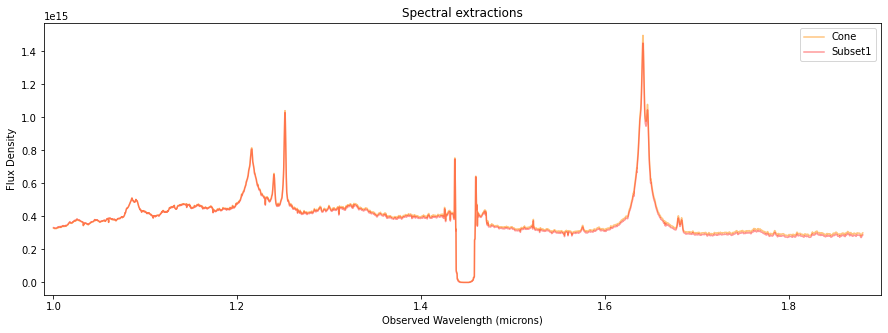

In [9]:
print(len(wavelength))
print(len(spectrum_subset1.flux.value))
f, (ax1) = plt.subplots(1, 1, figsize=(15, 5)) 

ax1.set_title("Spectral extractions")
ax1.set_xlabel("Observed Wavelength (microns)")  
ax1.set_ylabel("Flux Density")
ax1.set_xlim(0.99, 1.9)
#ax1.set_ylim(0, 0.6)

ax1.plot(wavelength, cone.flux.value, label="Cone", c='darkorange', alpha=0.5)
try:
    ax1.plot(wavelength, spectrum_subset1.flux.value, c='r', label="Subset1", alpha=0.4)
except Exception:
    print("There is no Cubeviz Subset1 spectrum to plot.")
ax1.legend()

plt.show()

Comparison of the conical and Cubeviz subset spectral extractions. 
The conical extraction captures slightly more flux at long wavelengths.
Red-shifted Broad Balmer and narrow [O III] lines  are visible in the quasar spectra. 

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Patrick Ogle.